Import Requirements

In [1]:
import os
import math
import random

import cv2
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

Set the Hyperparameters

In [2]:
model_name = "efficientnet_b0"
weights = None #"imagenet"
input_dims = (128, 128, 3)
num_classes = 101
epochs = 250
batch_size = 256
shuffle_size = 16
learning_rate = 0.01
precision = "float32"
model_dir = "models"
testing_set = 0.15

Create the Models

In [3]:
models = {
    'efficientnet_b0': tf.keras.applications.EfficientNetB0,
    'efficientnet_b1': tf.keras.applications.EfficientNetB1,
    'efficientnet_b2': tf.keras.applications.EfficientNetB2,
    'efficientnet_b3': tf.keras.applications.EfficientNetB3,
    'efficientnet_b4': tf.keras.applications.EfficientNetB4,
    'efficientnet_b5': tf.keras.applications.EfficientNetB5,
    'efficientnet_b6': tf.keras.applications.EfficientNetB6,
    'efficientnet_b7': tf.keras.applications.EfficientNetB7
}
inputs = tf.keras.Input(shape=input_dims)
backbone = models[model_name](include_top=True,
                        weights=weights,
                        input_shape=input_dims,
                        classes=num_classes)(inputs)
backbone.trainable = True
model = tf.keras.Model(inputs=inputs, outputs=backbone, name=model_name)

In [4]:
model.summary()

Model: "efficientnet_b0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 101)              4178952   
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


Import test training data (MNIST)

In [5]:
"""
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape)
print(y_train.shape)
"""

'\n(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()\nprint(x_train.shape)\nprint(y_train.shape)\n'

Import Real Training Data

In [27]:
x_train = []
y_train = []
labels_list = []

labels = os.listdir("data")
label_cn = 0
for label in labels:
    images_in_labels = os.listdir("data/" + label)
    for image in images_in_labels:
        labels_list.append(image)
        sub_images = os.path.join("data", label, image)
        for _t in os.listdir(sub_images):
            try:
                if _t.endswith(".jpg"):
                    im = np.array(
                            cv2.imread(
                                os.path.join(sub_images, _t)))
                    if len(im.shape) == 3:
                        x_train.append(im)
                        y_train.append(int(label))
            except:
                pass
    label_cn += 1

Preprocessing

In [9]:
def augment_preprocess(image):
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (input_dims[0], input_dims[1]))
    return image

def one_hot(indicies):
    return tf.one_hot(indicies, num_classes)[0]

In [16]:
x_training_np = [augment_preprocess(image) for image in x_train]
y_training_np = [one_hot([label]) for label in y_train]

# training_set = random.shuffle(list(zip(x_training_np, y_training_np)))
# x_training_np, y_training_np = zip(*training_set)

x_training_np = np.array(x_training_np)
y_training_np = np.array(y_training_np)

In [17]:
print("Training image shapes " + str(x_training_np.shape))
print("Training label shapes " + str(y_training_np.shape))

print("Training set size " + str(len(x_training_np)))

Training image shapes (8179, 128, 128, 3)
Training label shapes (8179, 101)
Training set size 8179


Datagenerator

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
train_datagen = ImageDataGenerator(rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8])  # brightness

Training Settings

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

In [21]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join(model_dir, model_name, "tensorboard"),
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None)

Training

In [22]:
model.compile(optimizer=optimizer, loss=loss_func, metrics=["accuracy", "categorical_crossentropy"])
model.fit(train_datagen.flow(x_training_np, y_training_np, batch_size=batch_size), epochs=epochs, shuffle=True)

Epoch 1/250
32/32 [==============================] - 35s 661ms/step - loss: 4.4002 - accuracy: 0.0752 - categorical_crossentropy: 4.4002
Epoch 2/250
32/32 [==============================] - 20s 606ms/step - loss: 3.8216 - accuracy: 0.0873 - categorical_crossentropy: 3.8216
Epoch 3/250
32/32 [==============================] - 20s 607ms/step - loss: 3.5690 - accuracy: 0.1316 - categorical_crossentropy: 3.5690
Epoch 4/250
32/32 [==============================] - 20s 612ms/step - loss: 3.3678 - accuracy: 0.1725 - categorical_crossentropy: 3.3678
Epoch 5/250
32/32 [==============================] - 19s 570ms/step - loss: 3.2342 - accuracy: 0.1945 - categorical_crossentropy: 3.2342
Epoch 6/250
32/32 [==============================] - 20s 617ms/step - loss: 3.0767 - accuracy: 0.2264 - categorical_crossentropy: 3.0767
Epoch 7/250
32/32 [==============================] - 20s 617ms/step - loss: 2.9707 - accuracy: 0.2483 - categorical_crossentropy: 2.9707
Epoch 8/250
32/32 [======================

In [23]:
tf.keras.models.save_model(model, os.path.join(model_dir, model_name, "model_final_101_recycling_fp32"))

INFO:tensorflow:Assets written to: models\efficientnet_b0\model_final_101_recycling_fp32\assets


INFO:tensorflow:Assets written to: models\efficientnet_b0\model_final_101_recycling_fp32\assets


Testing

In [24]:
model.evaluate(x_training_np, y_training_np, batch_size=batch_size)

32/32 [==============================] - 5s 105ms/step - loss: 0.1109 - accuracy: 0.9681 - categorical_crossentropy: 0.1109


[0.11094701290130615, 0.9680889844894409, 0.11094701290130615]

Visual Testing

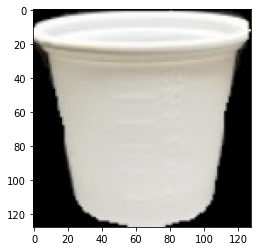

paperCup


In [31]:
test_index = 679
plt.imshow(x_training_np[test_index])
plt.show()
pred_index = tf.math.argmax(tf.squeeze(model(tf.expand_dims(x_training_np[test_index], axis=0), training=False), axis=0))
prediction = labels_list[pred_index]
print(prediction)

In [32]:
print(labels_list)

['plasticBag', 'dirtyBag', 'helmet', 'plasticCup', 'paperCup', 'styroCup', 'paperBento', 'receipt', 'chipBag', 'rubberBand', 'chipCan', 'pizzaBox', 'rainCoat', 'porcelain', 'portablePaperBag', 'comb', 'soapDispenser', 'mask', 'trashBag', 'rawKitchenWaste', 'cookedFoodWaste', 'plasticSpoon', 'eggCarton', 'pen', 'plushToy', 'facialCleanser', 'productPackaging', 'onionBag', 'chargingCable', 'pottedPlants', 'yakult', 'advertisingFlyer', 'transparentContainer', 'wood', 'lunchTray', 'creamers', 'cigaretteCase', 'yogaMat', 'toiletBrush', 'paperDiapers', 'fruitNet', 'milkCarton', 'disposableChopsticks', 'waterFilter', 'headphones', 'phoneCase', 'yogurtCup', 'mirror', 'bubbleWrap', 'litter', 'lipstick', 'shreddedPaper', 'shoe', 'foamPeanuts', 'coatHanger', 'pencil', 'newspaper', 'hotCoffeeCup', 'boosterPack', 'spoutBag', 'snackPaperBag', 'aluminumFoil', 'quiltPillow', 'plasticStraw', 'wasteMedicine', 'instantNoodleBowl', 'glassBottle', 'whiteout', 'toy', 'staple', 'capsuleCoffee', 'coffeePod', 